In [1]:
import numpy as np
import matplotlib.pyplot as pl

In [2]:
GM = 4 * np.pi # AU^3 / yr^2

In [93]:
#you won't have my style sheet so don't bother running this cell
pl.style.use("~/Documents/configs/custom.mplstyle")
pl.rcParams['axes.xmargin'] = 0.05

In [161]:
def grav_acc(r, gm=GM):
    r_mag = np.sqrt(np.sum(r**2))
    return -gm / r_mag**3 * r/r_mag

def energy(x, gm=GM):
    return -gm/np.sqrt(np.sum(x[0]**2)) + np.sum(x[1]**2) / 2

def rp(a, e):
    return a*(1-e)

def vp(a, e, gm=GM):
    return (gm * (1+e) / a / (1-e))**0.5

def rk_4(x, dt):
    k1 = dt * np.array([x[1], grav_acc(x[0])])
    k2 = dt * np.array([(x+k1/2)[1], grav_acc((x+k1/2)[0])])
    k3 = dt * np.array([(x+k2/2)[1], grav_acc((x+k2/2)[0])])
    k4 = dt * np.array([(x+k3)[1], grav_acc((x+k3)[0])])
    #k1 = dt * np.array([x[1], grav_acc(x[0])])
    #k2 = dt * np.array([x[1], grav_acc((x+k1/2)[0])])
    #k3 = dt * np.array([x[1], grav_acc((x+k2/2)[0])])
    #k4 = dt * np.array([x[1], grav_acc((x+k3)[0])])
    return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def integrate_orbit(method, n, t, r0=None, v0=None, a=1, e=0):
    if not r0 and not v0:
        r0 = [0, rp(a,e)]
        v0 = [-vp(a,e), 0]

    dt = t/n
    x = np.zeros((2,2,n))
    x[:,:,0] = np.array([r0, v0])
    for i in range(n-1):
        x[:,:,i+1] = method(x[:,:,i], dt)


    tot_en = [energy(x[:,:,i]) for i in range(n)]

    return x, tot_en

In [ ]:
pos, en = integrate_orbit(rk_4, 1000, )

In [183]:
x = pos[0,0,:].flatten()
y = pos[0,1,:].flatten()


circx = np.linspace(-1,1,200)
circy = np.sqrt(1-circx**2)

circ = np.array([np.hstack((circx,np.flip(circx))),np.hstack((circy,np.flip(-circy)))])

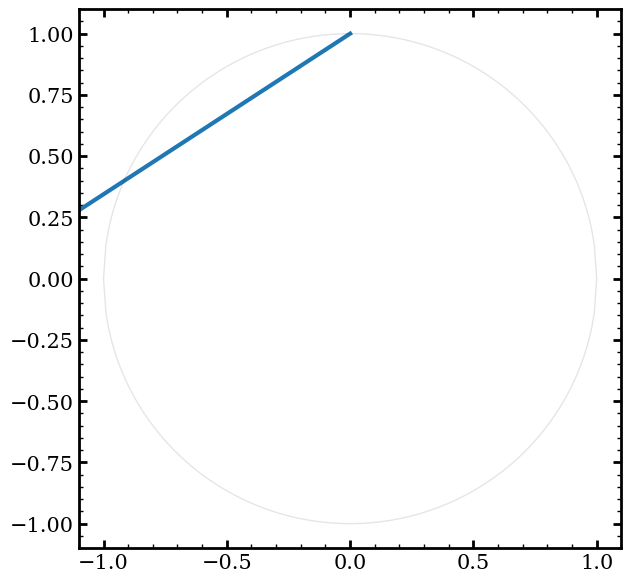

In [184]:
pl.figure(figsize=(7,7))
pl.plot(x,y)
pl.plot(circ[0], circ[1], c='k', alpha=0.1, lw=1)
pl.xlim(-1.1, 1.1)
pl.ylim(-1.1, 1.1)
pl.show()

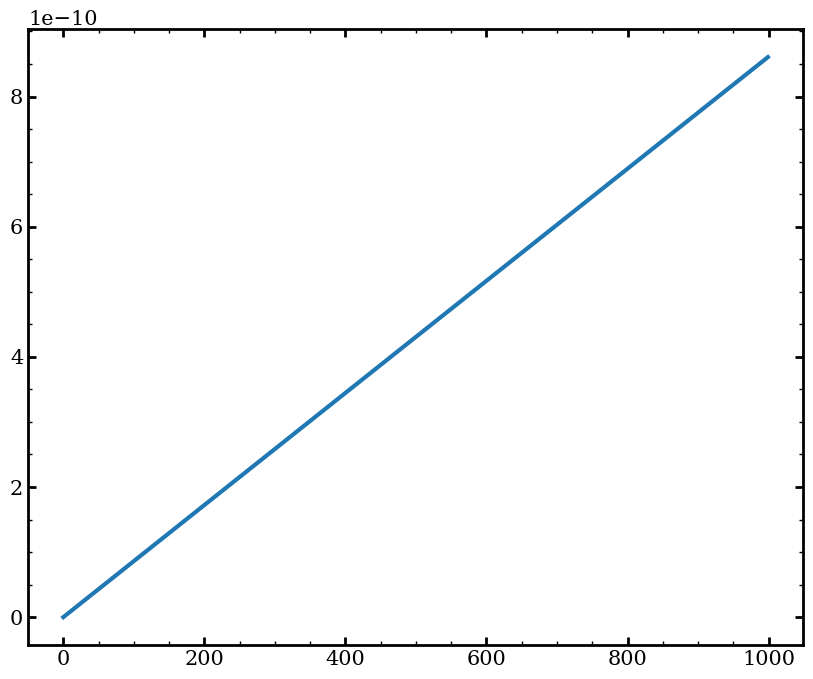

In [181]:
pl.plot(range(len(en)), en / en[0] - 1)
pl.show()

In [170]:
en

[-6.283185307179587,
 -6.283185307179734,
 -6.283185307179882,
 -6.2831853071800285,
 -6.283185307180174,
 -6.283185307180319,
 -6.283185307180466,
 -6.283185307180613,
 -6.2831853071807595,
 -6.283185307180906,
 -6.283185307181052,
 -6.2831853071812,
 -6.283185307181347,
 -6.283185307181491,
 -6.28318530718164,
 -6.283185307181784,
 -6.283185307181933,
 -6.283185307182078,
 -6.283185307182225,
 -6.283185307182371,
 -6.283185307182518,
 -6.283185307182666,
 -6.283185307182813,
 -6.283185307182959,
 -6.283185307183105,
 -6.283185307183252,
 -6.283185307183398,
 -6.283185307183547,
 -6.283185307183692,
 -6.283185307183839,
 -6.283185307183986,
 -6.283185307184132,
 -6.2831853071842785,
 -6.283185307184426,
 -6.283185307184571,
 -6.283185307184717,
 -6.283185307184863,
 -6.28318530718501,
 -6.283185307185157,
 -6.283185307185304,
 -6.28318530718545,
 -6.283185307185596,
 -6.283185307185744,
 -6.283185307185889,
 -6.283185307186035,
 -6.283185307186181,
 -6.28318530718633,
 -6.283185307186